# 1. Introduction
[NASA HI-SEAS](https://hi-seas.org/) missions act as a testbed and training ground for humans as we develop the capability to explore Mars. 
A recent NASA Space Apps Challenge hackathon asked participants to use data collected from the HI-SEAS site to predict solar radiation given a set of measurable meteorological conditions.
Knowing when conditions are most favorable for incident solar radiation is crucial for deciding when and where to deploy solar energy harvesting equipment, especially for colonists or astronauts on the surface of Mars.

The original Kaggle dataset & competition can be found here: https://www.kaggle.com/dronio/SolarEnergy

## 1.1. Scenario
We are participants in a NASA HI-SEAS (Hawai’i Space Exploration Analog and Simulation) mission, simulating a human settlement on Mars. 

A large solar array and battery bank are installed at the settlement and are the only power source available.
On sunny days, the array collects enough energy to power the entire settlement and recharge the battery bank.
The battery bank is used (sparingly) at night and on overcast days.
There is a strict power budget for operations each day to make sure vital equipment stays online, and we also have a number of experiments to run.

We have been collecting data at our settlement since the end of the last HI-SEAS mission in September, 2016.
It is now January, 2017, and our mission is about to begin.

Can we model solar radiation as a function of the information our sensors can gather, based on previously collected data?

## 1.2. About this dataset
These datasets are meteorological data from the HI-SEAS weather station from four months (September through December 2016) between Mission IV and Mission V.

For each dataset, the fields are:

A row number (1-n) is useful in sorting this export's results The UNIX time_t date (seconds since Jan 1, 1970). Useful in sorting this export's results with other export's results The date in `yyyy-mm-dd` format The local time of day in `hh:mm:ss` 24-hour format The numeric data, if any (may be an empty string) The text data, if any (may be an empty string)

The units of each dataset are:

* Solar radiation: watts per meter^2
* Temperature: degrees Fahrenheit
* Humidity: percent
* Barometric pressure: Hg
* Wind direction: degrees
* Wind speed: miles per hour
* Sunrise/sunset: Hawaii time

## 1.3. About this kernel
The purpose of this kernel is to explore this dataset and apply basic machine learning techniques in order to predict optimal conditions for maximal radiation.

This is my first foray into the world of data science and machine learning (ML). 
As such, it is expected that the following code will not be optimized for memory, runtime, or readability.
However, the result is still expected to be at worst interesting, at most useful.

I have decided to use Python 3 since it is widely used for data science, a versatile and useful language (even outside of data processing and ML), and a new language to me -- I'd like the practice.

## 1.4. Thanks
I would like to thank the following groups and individuals for providing the tutorials, resources, and inspiration to conduct this study.
* [NASA & Kaggle](https://www.kaggle.com/dronio/SolarEnergy), for providing this dataset.
* [sentdex on YouTube](https://www.youtube.com/playlist?list=PLQVvvaa0QuDfKTOs3Keq_kaG2P55YRn5v), for his incredible series on machine learning and everything else Python.
* Sarah Linden, for encouraging me to do engineering projects in my free time.

# 2. Preprocessing the data
Before applying any machine learning techniques, the input data must be ingested and conditioned.
Not all the data provided is useful!

## 2.1. Defining Features and Labels
Machine learning algorithms operate on _features_ to predict _labels_.

* A __feature__ is an attribute of the system that affects the output. 
Features act as "inputs" to the model.
Ideally, features are _independent_ variables.
* A __label__ is the value being predicted. 
Labels act as "outputs" of the model.

Now, let's consider our scenario. 
Recall the available data:
* Date
* Time of Day 
* Solar Radiation
* Temperature
* Pressure
* Humidity
* Wind Direction
* Wind Speed
* Time at Sunrise
* Time at Sunset

### 2.1.1. Features
At every timestamp within each day, there are values for all other variables.
No other variables impact the values of time or date.
Therefore __date__ and __time of day__ are _independent_ variables.

For each date, there is _one_ value for `Time at Sunrise` and `Time at Sunset`. 
The difference of these values yields the length of a given day, which is directly related to the date.
More exploration of the dataset is needed to determine if the length of a given date supersedes `date` in the amount of useful information it provides.

Temperature, pressure, and humidity do not directly affect one another significantly, but since they are all properties which describe the local atmosphere, they do not vary independently from one another.
Similarly, all three of these variables have a stong relationship to time of day. 

Therefore we consider the following variables to be _features_ to the machine learning algorithm:
* Date (or Length of Day)
* Time of day
* Temperature
* Pressure
* Humidity

Further exploration of the dataset may modify this list, but for now this is our best guess.

### 2.1.2. Labels
While one's instinct may be to consider `Radiation` to be a label, recall that the goal of this algorithm is to _predict_ the radiation level. 
A more effective label is the __predicted radiation__. Recorded radiation measurements serve as the truth values to train and test the supervised machine learning algorithm.

### 2.1.3. Irrelevant Data
Wind speed and wind direction are also properties of the atmosphere, but do not significantly affect the optical throughput of the atmosphere -- at least, not enough to skew the solar radiation measured incident to the HI-SEAS solar array.
Therefore, wind speed and wind direction are considered irrelevant to this study and omitted from the dataset.

## 2.2. Importing the Data
First, all of the data is loaded in as the appropriate data types.
The column `Data` contains a single, unchanging timestamp. This appears to be the dat the dataset was published, but that is unclear.
For our purposes, this is not useful information and the column is removed from the dataset.

All units are converted into their SI counterparts (if they are not already in SI units).
Time of day, sunrise, and sunset values are converted to `datetime` objects which are stored as timezone naive UNIX time values (we can always translate it back later).

In [7]:
## IMPORT LIBRARIES
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

def ingest_data(filename):
    '''Read data from a CSV file and construct a pandas DataFrame
    Inputs:
        filename as string
    Outputs:
        df as DataFrame
    '''
    # read csv file
    df = pd.read_csv(filename)

    # 'Data' column is unused. All elements contain the same value.
    df.drop(['Data','WindDirection(Degrees)','Speed','Time'],axis=1,inplace=True)

    # interpret columns as appropriate data types to ensure compatibility
    df['UNIXTime']      = df['UNIXTime'].astype(str)
    df['Radiation']     = df['Radiation'].astype(float)
    df['Temperature']   = df['Temperature'].astype(float) # or int
    df['Pressure']      = df['Pressure'].astype(float)
    df['Humidity']      = df['Humidity'].astype(int) # or int
    df['TimeSunRise']   = df['TimeSunRise'].astype(str)
    df['TimeSunSet']    = df['TimeSunSet'].astype(str)

    # convert units to SI
    df.loc[:,'Temperature'] = (df.loc[:,'Temperature'] + 459.67)*5.0/9.0 # degrees F --> Kelvin
    df.loc[:,'Pressure'] *= 3386.0 # inches Hg --> Pascal

    # convert times to UNIX timestamp, time zone naive
    df['UNIXTime'] = pd.to_datetime(df['UNIXTime'],unit='s')
    df['TimeSunRise'] = pd.to_datetime(df['TimeSunRise'],format='%H:%M:%S')
    df['TimeSunSet'] = pd.to_datetime(df['TimeSunSet'],format='%H:%M:%S')

    # compute length of each day
    df['DayLength'] = (df['TimeSunSet']-df['TimeSunRise'])/np.timedelta64(1, 's')

    # we don't need sunrise or sunset times anymore, so drop them
    df.drop(['TimeSunRise','TimeSunSet'],axis=1,inplace=True)

    # break down UNIX time into calendar and time components
    df['Month'] = df['UNIXTime'].dt.month
    df['Day'] = df['UNIXTime'].dt.day
    df['Hour'] = df['UNIXTime'].dt.hour # for easier grouping and math
    df['Minute'] = df['UNIXTime'].dt.minute + 60/df['UNIXTime'].dt.second # seconds as decimal of minute

    df.sort_values('UNIXTime',inplace=True) # sort by UNIXTime

    # assign unit labels to data keys
    units={'Time':'HST (UTC-10)','Radiation':'W/m^2','Temperature':'K','Pressure':'Pa','Humidity':'\%','DayLength':'sec'}
    return df, units

In [8]:
df, units = ingest_data('input/SolarPrediction.csv')
print(df.head())

                UNIXTime  Radiation  Temperature   Pressure  Humidity  \
7416 2016-09-01 10:00:08       2.58   283.705556  103035.98       103   
7415 2016-09-01 10:05:10       2.83   283.705556  103035.98       103   
7414 2016-09-01 10:20:06       2.16   283.705556  103035.98       103   
7413 2016-09-01 10:25:05       2.21   283.705556  103035.98       103   
7412 2016-09-01 10:30:09       2.25   283.705556  103035.98       103   

      DayLength  Month  Day  Hour     Minute  
7416    45060.0      9    1    10   7.500000  
7415    45060.0      9    1    10  11.000000  
7414    45060.0      9    1    10  30.000000  
7413    45060.0      9    1    10  37.000000  
7412    45060.0      9    1    10  36.666667  


Note that the `Time` column is dropped in favor of the `UNIXTime` timestamp. 
UNIX time encodes both date and time, so the `Time` column is redundant.
UNIX time is converted from UTC to Hawaii Standard Time, then data is sorted by UNIX time.

Month, day, hour, and minute are separated into their own columns for grouping and other plotting purposes, such as specifying histogram bins.
UNIXTime contains all the same information but `datetime` objects are not as easy to handle as integers and floats.

## 2.3. Exploring the Data
Plotting libraries are imported to visualize data.

In [9]:
import matplotlib.pyplot as plt # plotting tools
import seaborn as sns # statistical plotting tools

# make IPython render plots inline
%matplotlib inline 

There are several timescales to consider here:
* Monthly
* Daily
* Hourly

Looking into data by the minute is too granular to draw broad conclusions at this stage, but something to be considered when constructing the prediction algorithm.

Radiation is expected vary with the date due to seasonal weather changes. 
The dataset only contains data from autumn and winter, so the model developed from this data may be less capable of predicting radiation during the summer. 
Fortunately, the seasonal climate at the HI-SEAS facility in Hawai'i is fairly consistent year-round.

Recalling the features identified in 2.1.1, we plot Radiation as a function of Temperature, Humidity, and Pressure on the various timescales.

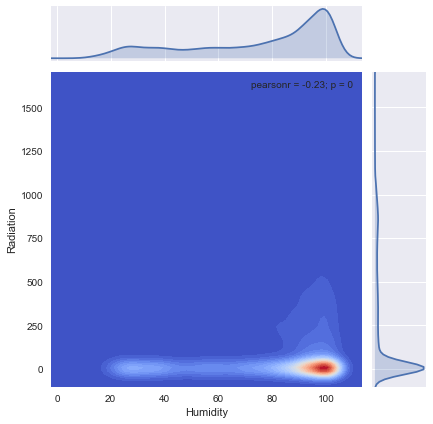

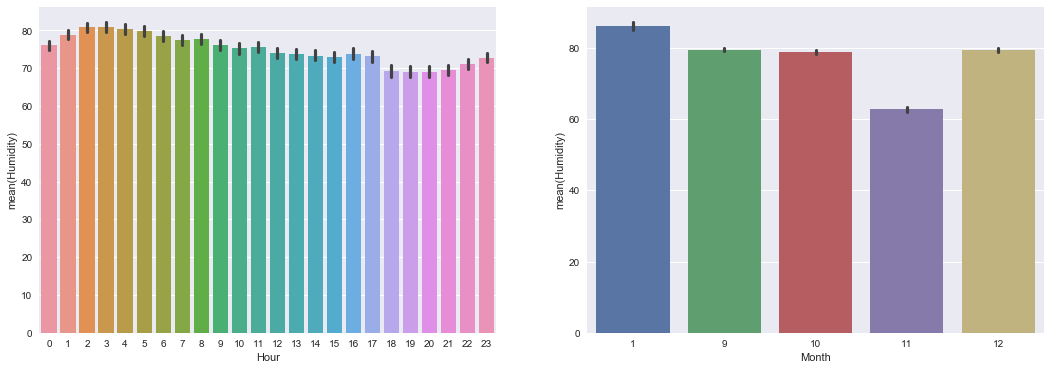

In [10]:
def humidity(df):
    '''Plot humidity vs radiation over time'''
    sns.jointplot(x='Humidity',y='Radiation',data=df,kind='kde',cmap='coolwarm',n_levels=30,shade=True)
    plt.figure(figsize=(18, 6))
    plt.subplot(121)
    sns.barplot(x='Hour',y='Humidity',data=df)
    plt.subplot(122)
    sns.barplot(x='Month',y='Humidity',data=df)
    sns.plt.show()
    
humidity(df)

# 3. Preparing the Prediction Algorithm
We desire an algorithm that will predict values (radiation for a given set of inputs), we have plenty of data to train with, and we have "unlimited" time. Thus, we select a __regression__ model.
There are many regression models to choose from like Linear Regression and Neural Networks, and there may be more than one that is appropriate.

Even before we downselect to a specific model, we can prepare a prediction algorithm that takes in our data and makes a prediction.
Using [`scikit learn`](http://scikit-learn.org/stable/supervised_learning.html#supervised-learning), it is easy to swap out different models and maintain the same higher-level structure to the program.